<a href="https://colab.research.google.com/github/bdgroves/desert-ecostats/blob/main/Death_Valley_Ecosystems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 🏜️ Death Valley National Park: Geospatial & Remote Sensing Analysis
"""
This notebook explores terrain, water index, and points of interest within Death Valley National Park using a combination of vector and raster geospatial techniques.

We'll demonstrate:
- Using DEMs (Digital Elevation Models) for terrain analysis
- Computing NDWI from multispectral imagery to highlight potential water presence
- Reprojecting and comparing datasets
- Mapping important sites within Death Valley (like Furnace Creek & Badwater Basin)

---

## 🔧 Setup: Install & import libraries
"""

"\nThis notebook explores terrain, water index, and points of interest within Death Valley National Park using a combination of vector and raster geospatial techniques.\n\nWe'll demonstrate:\n- Using DEMs (Digital Elevation Models) for terrain analysis\n- Computing NDWI from multispectral imagery to highlight potential water presence\n- Reprojecting and comparing datasets\n- Mapping important sites within Death Valley (like Furnace Creek & Badwater Basin)\n\n---\n\n## 🔧 Setup: Install & import libraries\n"

In [3]:
# Install in Colab
!pip install geopandas rasterio folium matplotlib numpy -v

import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import folium
import matplotlib.pyplot as plt
from shapely.geometry import Point

Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
  Obtaining dependency information for rasterio from https://files.pythonhosted.org/packages/aa/fa/723fa6a48a419b044146cd92fa6a66ead8532d96c352fbc2f2a1546cb5b6/rasterio-1.4.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for affine from https://files.pythonhosted.org/packages/0b/f7/85273299ab57117850cc0a936c64151171fac4da49bc6fba0dad984a7c5f/affine-2.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for cligj>=0.5 from https://files.pythonhosted.org/packages/73/86/43fa9f15c5b9fb6e82620428827cd3c284aa933431405d1bcf5231ae3d3e/cligj-0.7.2-py3-none-any.whl.metadata
  Obtaining dependency information for click-plugins from https://files.pythonhosted.org/packages/3d/9a/2abecb28ae875e39c8cad711eb1186d8d14eab564705325e77e4e6ab9ae5/click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 87.2 M

In [ ]:
# Create GeoDataFrame of POIs
poi_data = {
    "name": ["Furnace Creek", "Badwater Basin", "Mesquite Dunes"],
    "latitude": [36.4631, 36.2502, 36.6059],
    "longitude": [-116.8656, -116.8258, -117.1158]
}
poi_df = pd.DataFrame(poi_data)
poi_gdf = gpd.GeoDataFrame(
    poi_df,
    geometry=[Point(xy) for xy in zip(poi_df['longitude'], poi_df['latitude'])],
    crs="EPSG:4326"
)

# Map with Folium
m = folium.Map(location=[36.5, -116.9], zoom_start=10, tiles="cartodbpositron")
for idx, row in poi_gdf.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='green')
    ).add_to(m)
m


DEM Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4269, 'height': 3113, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'), 'transform': Affine(90.0, 0.0, -13442488.3428,
       0.0, -89.99579177642138, 4668371.5775)}


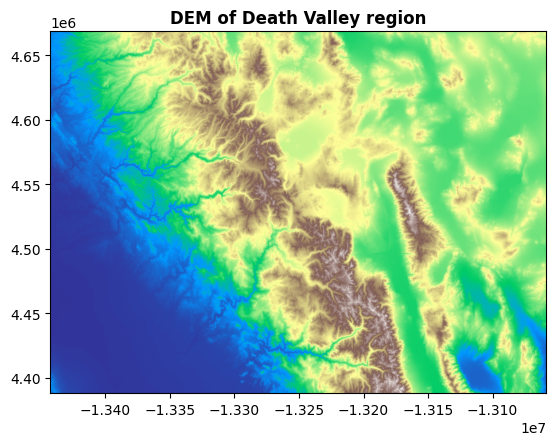

In [4]:
# Download the DEM
!wget -q https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif

# Open and explore the raster with rasterio
import rasterio
from rasterio.plot import show

dem_path = "dem_90m.tif"
with rasterio.open(dem_path) as dem_src:
    print("DEM Metadata:", dem_src.meta)
    show(dem_src, cmap='terrain', title="DEM of Death Valley region")


Multispectral bands: 4


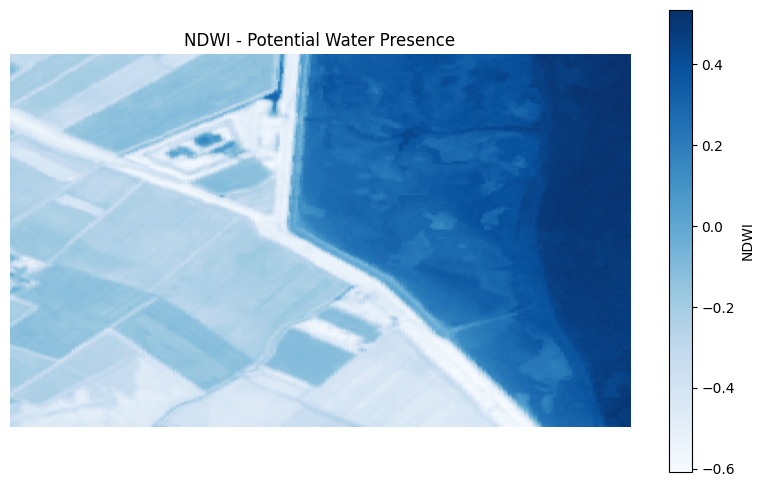

In [6]:
# Download multispectral image (4 bands)
!wget -q https://github.com/opengeos/datasets/releases/download/raster/cog.tif

# Open
multi_path = "cog.tif"
with rasterio.open(multi_path) as multi_src:
    print("Multispectral bands:", multi_src.count)

    # Read all bands into a numpy array
    all_bands = multi_src.read()

    # Extract Green (band 3) & NIR (band 4) from the array
    # Note: rasterio reads bands into a (bands, rows, cols) array, and is 1-indexed in .read() but 0-indexed in the array
    green = all_bands[2].astype(float)  # Band 3 is at index 2
    nir = all_bands[3].astype(float)    # Band 4 is at index 3


    # Compute NDWI
    ndwi = np.where(
        (green + nir) == 0.,
        0,
        (green - nir) / (green + nir)
    )

    plt.figure(figsize=(10, 6))
    plt.imshow(ndwi, cmap='Blues')
    plt.colorbar(label="NDWI")
    plt.title("NDWI - Potential Water Presence")
    plt.axis('off')
    plt.show()

In [7]:
## 💾 Save NDWI raster
ndwi_path = "death_valley_ndwi.tif"
with rasterio.open(multi_path) as src:
    meta = src.meta.copy()
    meta.update({
        "count": 1,
        "dtype": rasterio.float32
    })
    with rasterio.open(ndwi_path, "w", **meta) as dst:
        dst.write(ndwi.astype(rasterio.float32), 1)
print(f"NDWI saved to {ndwi_path}")


NDWI saved to death_valley_ndwi.tif


In [8]:
reprojected_path = "reprojected_dem.tif"
with rasterio.open(dem_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, "EPSG:4326", src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": "EPSG:4326",
        "transform": transform,
        "width": width,
        "height": height
    })

    with rasterio.open(reprojected_path, "w", **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs="EPSG:4326",
                resampling=Resampling.nearest
            )
print(f"Reprojected DEM saved to {reprojected_path}")


Reprojected DEM saved to reprojected_dem.tif
